## Cats and Dogs classifier using Multi-Model Transfer Learning and tf.data

Great article from Vardan Agarwal on how to join 3 models into a single inference.  I used my existing transfer learning example located in this subdirectory and added his logic for multiple models.  

Modifications from his article:
- Changed the number of EPOCS from 20 to 1 because it trains quickly with some extra Dense layers.  EPOCS can be changed to 2, 3 or 4 if you want higher accuracy.   
- Added a method call for setting non-trainable layers.
- Used a dictionary for merged model feed
  
Article: https://towardsdatascience.com/destroy-image-classification-by-ensemble-of-pre-trained-models-f287513b7687

Colab: https://colab.research.google.com/gist/vardanagarwal/dfbe55382dc6051440dadf1d377f96c7/pre-trained_ensemble.ipynb#scrollTo=8bkfJIRv6Dbh




In [16]:
#"""
# Google Collab specific stuff....
from google.colab import drive
drive.mount('/content/drive')

import os
!ls "/content/drive/My Drive"

USING_COLLAB = True
%tensorflow_version 2.x
#"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'   DiekhoffStorage   GitHub   ImageData


In [17]:
# Setup sys.path to find MachineLearning lib directory

try: USING_COLLAB
except NameError: USING_COLLAB = False

%load_ext autoreload
%autoreload 2

import sys
if "MachineLearning" in sys.path[0]:
    pass
else:
    print(sys.path)
    if USING_COLLAB:
        sys.path.insert(0, '/content/drive/My Drive/GitHub/MachineLearning/lib') ###### CHANGE FOR SPECIFIC ENVIRONMENT
    else:
        sys.path.insert(0, '/Users/john/Documents/GitHub/MachineLearning/lib')  ###### CHANGE FOR SPECIFIC ENVIRONMENT
    
    print(sys.path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys, random, warnings, time, copy, csv, gc
import numpy as np 

import IPython.display as display
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange, tqdm
import pandas as pd

import tensorflow as tf
print(tf.__version__)

import tensorflow_datasets as tfds

AUTOTUNE = tf.data.experimental.AUTOTUNE
print("AUTOTUNE: ", AUTOTUNE)

from TrainingUtils import *

#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

2.2.0
AUTOTUNE:  -1


## Examine and understand data


In [19]:
# GLOBALS/CONFIG ITEMS

# Set root directory path to data
if USING_COLLAB:
    ROOT_PATH = "/content/drive/My Drive/ImageData/DogsCats"  ###### CHANGE FOR SPECIFIC ENVIRONMENT
else:
    ROOT_PATH = "/Users/john/Documents/ImageData/DogsCats"  ###### CHANGE FOR SPECIFIC ENVIRONMENT
        
# Establish global dictionary
parms = GlobalParms(MODEL_NAME="model-multi-CatsDogs-V01.h5",
                    ROOT_PATH=ROOT_PATH,
                    TRAIN_DIR="train", 
                    SMALL_RUN=False,
                    NUM_CLASSES=2,
                    IMAGE_ROWS=224,
                    IMAGE_COLS=224,
                    IMAGE_CHANNELS=3,
                    BATCH_SIZE=8,
                    EPOCS=1,  # set larger as needed
                    IMAGE_EXT=".jpg",
                    FINAL_ACTIVATION='sigmoid',
                    LOSS='binary_crossentropy',
                    METRICS=['accuracy'])

parms.print_contents()

MODEL_NAMES = ['model1-multi-CatsDogs-tmp.h5', 'model2-multi-CatsDogs-tmp.h5', 'model3-multi-CatsDogs-tmp.h5']

{'keys_and_defaults': {'MODEL_NAME': '', 'ROOT_PATH': '', 'TRAIN_DIR': '', 'TEST_DIR': '', 'SUBMISSION_PATH': None, 'MODEL_PATH': None, 'TRAIN_PATH': None, 'TEST_PATH': None, 'SMALL_RUN': False, 'NUM_CLASSES': 0, 'CLASS_NAMES': [], 'IMAGE_ROWS': 0, 'IMAGE_COLS': 0, 'IMAGE_CHANNELS': 0, 'BATCH_SIZE': 0, 'EPOCS': 0, 'ROW_SCALE_FACTOR': 1, 'COL_SCALE_FACTOR': 1, 'IMAGE_EXT': '.jpg', 'IMAGE_DTYPE': <class 'numpy.float32'>, 'Y_DTYPE': <class 'int'>, 'LOAD_MODEL': False, 'SUBMISSION': 'submission.csv', 'METRICS': ['accuracy'], 'FINAL_ACTIVATION': 'sigmoid', 'LOSS': ''}, 'MODEL_NAME': 'model-multi-CatsDogs-V01.h5', 'ROOT_PATH': '/content/drive/My Drive/ImageData/DogsCats', 'TRAIN_DIR': 'train', 'TEST_DIR': '', 'SUBMISSION_PATH': '/content/drive/My Drive/ImageData/DogsCats/submission.csv', 'MODEL_PATH': '/content/drive/My Drive/ImageData/DogsCats/model-multi-CatsDogs-V01.h5', 'TRAIN_PATH': '/content/drive/My Drive/ImageData/DogsCats/train', 'TEST_PATH': '/content/drive/My Drive/ImageData/DogsC

In [0]:
# Simple helper method to display batches of images with labels....        
def show_batch(image_batch, label_batch, number_to_show=25, r=5, c=5, print_shape=False):
    show_number = min(number_to_show, parms.BATCH_SIZE)

    if show_number < 8: #if small number, then change row, col and figure size
        if parms.IMAGE_COLS > 64 or parms.IMAGE_ROWS > 64:
            plt.figure(figsize=(25,25)) 
        else:
            plt.figure(figsize=(10,10))  
        r = 4
        c = 2 
    else:
        plt.figure(figsize=(10,10))  

    if show_number == 1:
        image_batch = np.expand_dims(image_batch, axis=0)
        label_batch = np.expand_dims(label_batch, axis=0)

    for n in range(show_number):
        if print_shape:
            print("Image shape: {}  Max: {}  Min: {}".format(image_batch[n].shape, 
                                                             np.max(image_batch[n]), 
                                                             np.min(image_batch[n])))
        ax = plt.subplot(r,c,n+1)
        cmap="gray"
        if len(image_batch[n].shape) == 3:
            if image_batch[n].shape[2] == 3:
                cmap="viridis"
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_batch[n]), cmap=plt.get_cmap(cmap))

        plt.title(parms.CLASS_NAMES[np.argmax(label_batch[n])])

        plt.axis('off')


In [21]:
# Download dataset to local VM
full_dataset, info = tfds.load(name="cats_vs_dogs", with_info=True, split="train")
assert isinstance(full_dataset, tf.data.Dataset)
print(info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [22]:
# Set Class names...
parms.set_class_names(["Cat", "Dog"])
print("Classes: ", parms.NUM_CLASSES, 
      "   Labels: ", len(parms.CLASS_NAMES), 
      "  ", parms.CLASS_NAMES)


Classes:  2    Labels:  2    ['Cat', 'Dog']


In [23]:
!ls "/root/tensorflow_datasets/cats_vs_dogs"

4.0.0


## Build an input pipeline

In [0]:
def image_rescale_1_neg_1(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.resize(image, (parms.IMAGE_ROWS, parms.IMAGE_COLS))
    # takes Any scale and converts to 1..-1
    image = (tf.constant(2., dtype=tf.float32)*(image - tf.math.reduce_min(image))/(tf.math.reduce_max(image) - tf.math.reduce_min(image)))-1
    return image

def process_train_single(cat_dog_dict: tf.Tensor) -> tf.Tensor:
    image = cat_dog_dict["image"]
    label = cat_dog_dict["label"]
    image = image_rescale_1_neg_1(image)
    return image, label_to_onehot(label)


def process_val_single(cat_dog_dict: tf.Tensor) -> tf.Tensor:
    image = cat_dog_dict["image"]
    label = cat_dog_dict["label"]
    image = image_rescale_1_neg_1(image)
    return image, label_to_onehot(label)

def label_to_onehot(label: tf.Tensor) -> tf.Tensor:
    return tf.one_hot(label, parms.NUM_CLASSES)

In [25]:
# split into training and validation sets of images
images_list_len = info.splits['train'].num_examples

train_len = int(0.9 * images_list_len)
val_len = images_list_len - train_len

# Create datasets with new sizes
train_dataset = full_dataset.take(train_len)  #  Creates dataset with new size
val_dataset = full_dataset.skip(train_len)  # Creates dataset after skipping over the size

steps_per_epoch = np.ceil(train_len // parms.BATCH_SIZE) # set step sizes based on train & batch
validation_steps = np.ceil(val_len // parms.BATCH_SIZE) # set step sizes based on val & batch

print("Total number: ", images_list_len, "  Train number: ", train_len, "  Val number: ", val_len)
print("Steps/EPOC: ", steps_per_epoch, "  Steps/Validation: ", validation_steps)

Total number:  23262   Train number:  20935   Val number:  2327
Steps/EPOC:  2616.0   Steps/Validation:  290.0


### Training setup

In [26]:
# Verify image paths were loaded and save one path for later in "some_image"
for f in train_dataset.take(2):
    some_image = f["image"]
    some_label = f["label"]
    print(some_label)

# map training images to pre-cache processing, includes any augmentation
train_dataset = train_dataset.map(process_train_single, num_parallel_calls=AUTOTUNE)

# Verify the mapping worked
for image, label in train_dataset.take(1):
    print("Map 1 Image shape: {}  Max: {}  Min: {}".format(image.numpy().shape, np.max(image.numpy()), np.min(image.numpy())))
    print("Label: ", np.argmax(label.numpy()), label.numpy())

# Repeat forever
train_dataset = train_dataset.repeat()

# set the batch size
train_dataset = train_dataset.batch(parms.BATCH_SIZE)


tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
Map 1 Image shape: (224, 224, 3)  Max: 1.0  Min: -1.0
Label:  1 [0. 1.]


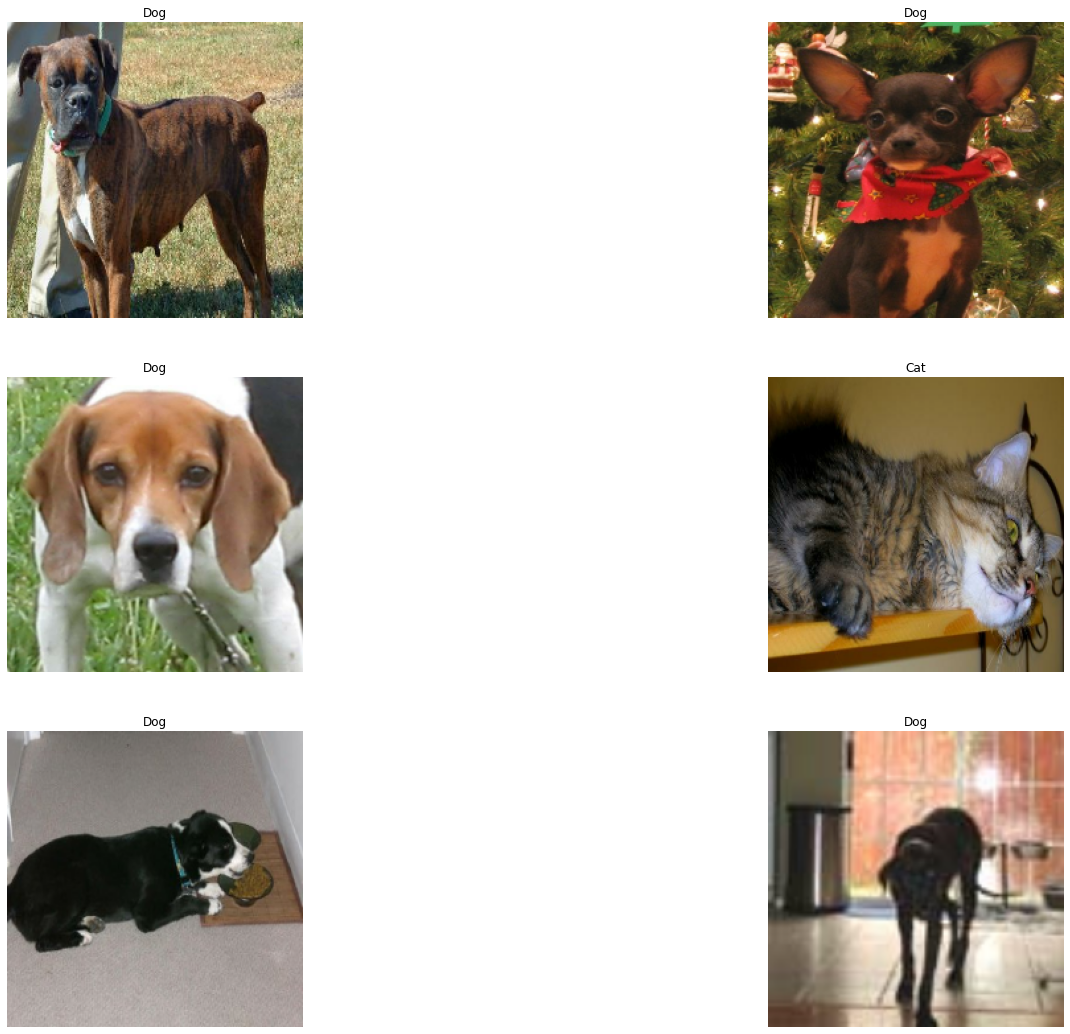

In [27]:
# Show the images, execute this cell multiple times to see the images

image_batch, label_batch = next(iter(train_dataset))
#show_batch(image_batch.numpy(), label_batch.numpy())
show_batch(image_batch.numpy(), label_batch.numpy(), print_shape=False, number_to_show=6)

### Validation setup

In [28]:
# Verify image paths were loaded and save one path for later in "some_image"
for f in val_dataset.take(2):
    some_label = f["label"]
    print(some_label)

# map training images to processing, includes any augmentation
val_dataset = val_dataset.map(process_val_single, num_parallel_calls=AUTOTUNE)

# Verify the mapping worked
for image, label in val_dataset.take(1):
    print("Image shape: {}  Max: {}  Min: {}".format(image.numpy().shape, np.max(image.numpy()), np.min(image.numpy())))
    print("Label: ", np.argmax(label.numpy()), label.numpy())

# Repeat forever
val_dataset = val_dataset.repeat()

# set the batch size
val_dataset = val_dataset.batch(parms.BATCH_SIZE)


tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
Image shape: (224, 224, 3)  Max: 1.0  Min: -1.0
Label:  0 [1. 0.]


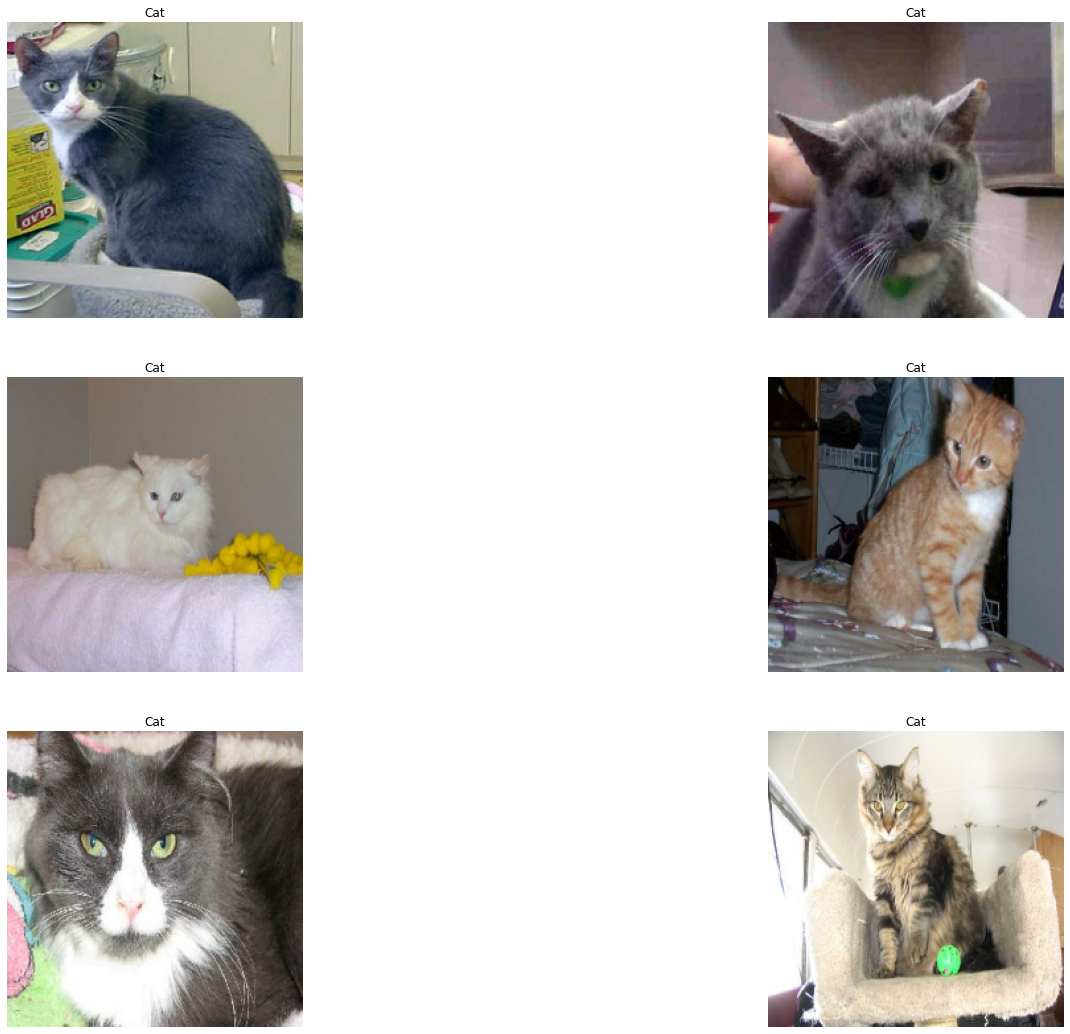

In [29]:
# Test Validation, use smaller "number_to_show" to help show the augmentation

image_batch, label_batch = next(iter(val_dataset))
#show_batch(image_batch.numpy(), label_batch.numpy())
show_batch(image_batch.numpy(), label_batch.numpy(), number_to_show=6)

## Build and Train each models

In [0]:
# Create model and compile it

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, Conv2DTranspose, Concatenate, Activation
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, Adam, Nadam, SGD
########

def set_train_layers(model, train_layers=20): #since 224x224x3, set the first 20 layers of the network to be non-trainable
    if train_layers == 0: #set all non-trainable
        for layer in model.layers:
            layer.trainable=False
    else:
        for layer in model.layers[:train_layers]:             
            layer.trainable=False
        for layer in model.layers[train_layers:]:
            layer.trainable=True
    return model

def build_compile_model(base_model):
    x=base_model.output
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    x=tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    x=tf.keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
    x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 3
    preds=tf.keras.layers.Dense(parms.NUM_CLASSES, activation=parms.FINAL_ACTIVATION)(x) #final layer
    model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

    model.compile(loss=parms.LOSS,
          optimizer=SGD(lr=0.001, momentum=0.9),
          metrics=parms.METRICS)

    return model


def fit_model(model):
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=parms.EPOCS, 
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps
                        )
    return history

def plot_history(history):
    # Plot the training history
    history_df = pd.DataFrame(history.history)
    plt.figure()
    history_df[['loss', 'val_loss']].plot(title="Loss")
    plt.xlabel('Epocs')
    plt.ylabel('Loss')
    history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy")
    plt.xlabel('Epocs')
    plt.ylabel('Accuracy')
    plt.show()


In [31]:
# Quick train on the models

base_model1 = tf.keras.applications.MobileNetV2(input_shape=parms.IMAGE_DIM, include_top=False, weights="imagenet")
base_model2 = tf.keras.applications.InceptionV3(input_shape=parms.IMAGE_DIM, include_top=False, weights="imagenet")
base_model3 = tf.keras.applications.Xception(input_shape=parms.IMAGE_DIM, include_top=False, weights="imagenet")

base_model1 = set_train_layers(base_model1)
model1 = build_compile_model(base_model1)

base_model2 = set_train_layers(base_model2, train_layers=0)
model2 = build_compile_model(base_model2)

base_model3 = set_train_layers(base_model3, train_layers=0)
model3 = build_compile_model(base_model3)

history1 = fit_model(model1)
model1.save(os.path.join(parms.ROOT_PATH, MODEL_NAMES[0]))

history2 = fit_model(model2)
model2.save(os.path.join(parms.ROOT_PATH, MODEL_NAMES[1]))

history3 = fit_model(model3)
model3.save(os.path.join(parms.ROOT_PATH, MODEL_NAMES[2]))


2616/2616 [==============================] - 183s 70ms/step - loss: 0.0561 - accuracy: 0.9838 - val_loss: 0.0316 - val_accuracy: 0.9892


In [0]:
# Plot results
if parms.EPOCS > 1:
    plot_history(history1)
    plot_history(history2)
    plot_history(history3)


# Build and Train Multi-Models


In [0]:
# Load, merge and compile the three models

def load_all_models():
    all_models = []
    for model_name in MODEL_NAMES:
        filename = os.path.join(parms.ROOT_PATH, model_name)
        model = tf.keras.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models

def build_compile_ensemble_model(models):
    for i, model in enumerate(models):
        for layer in model.layers:
            layer.trainable = False
    ensemble_visible = [model.input for model in models]
    ensemble_outputs = [model.output for model in models]
    merge = tf.keras.layers.concatenate(ensemble_outputs)
    merge = tf.keras.layers.Dense(10, activation='relu')(merge)
    output = tf.keras.layers.Dense(parms.NUM_CLASSES, activation='sigmoid')(merge)
    model = tf.keras.models.Model(inputs=ensemble_visible, outputs=output)
    print("input tensor ", ensemble_visible)
    model.compile(loss=parms.LOSS,
          optimizer=SGD(lr=0.001, momentum=0.9),
          metrics=parms.METRICS)
    return model

In [54]:
models = load_all_models()

model = build_compile_ensemble_model(models)

# Load model input names.  Need the names for the input dictionary
model1_input = models[0].input.name.split(":")[0][:-2]
model2_input = models[1].input.name.split(":")[0][:-2]
model3_input = models[2].input.name.split(":")[0][:-2]

# Double check the input names, print tensor when loading and actual names after loading
print("input names ", model1_input, model2_input, model3_input)

loaded: /content/drive/My Drive/ImageData/DogsCats/model1-multi-CatsDogs-tmp.h5
loaded: /content/drive/My Drive/ImageData/DogsCats/model2-multi-CatsDogs-tmp.h5
loaded: /content/drive/My Drive/ImageData/DogsCats/model3-multi-CatsDogs-tmp.h5
input tensor  [<tf.Tensor 'input_1_2:0' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'input_2_2:0' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'input_3_2:0' shape=(None, 224, 224, 3) dtype=float32>]
input names  input_1 input_2 input_3


In [0]:
# Create datasets with new sizes
train_dataset = full_dataset.take(train_len)  #  Creates dataset with new size
val_dataset = full_dataset.skip(train_len)  # Creates dataset after skipping over the size


In [0]:
# mapping methods for traina and val

@tf.function
def process_multi_tf(cat_dog_dict):
    image = cat_dog_dict["image"]
    label = cat_dog_dict["label"]
    image = image_rescale_1_neg_1(image)
    return {model1_input:image, model2_input:image, model3_input:image}, label_to_onehot(label)

def process_multi(cat_dog_dict: tf.Tensor) -> tf.Tensor:
    return process_multi_tf(cat_dog_dict)


In [0]:
# Build training and validation datasets
train_dataset = train_dataset.map(process_multi, num_parallel_calls=AUTOTUNE) \
                             .repeat() \
                             .batch(parms.BATCH_SIZE)

val_dataset = val_dataset.map(process_multi, num_parallel_calls=AUTOTUNE) \
                         .repeat() \
                         .batch(parms.BATCH_SIZE)


In [58]:
# Train multi model
history_multi = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=2, 
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps
                    )

model.save(parms.MODEL_PATH)

Epoch 1/2
2616/2616 [==============================] - 333s 127ms/step - loss: 0.1981 - accuracy: 0.9626 - val_loss: 0.0445 - val_accuracy: 0.9931
Epoch 2/2
2616/2616 [==============================] - 329s 126ms/step - loss: 0.0263 - accuracy: 0.9950 - val_loss: 0.0214 - val_accuracy: 0.9935


<Figure size 432x288 with 0 Axes>

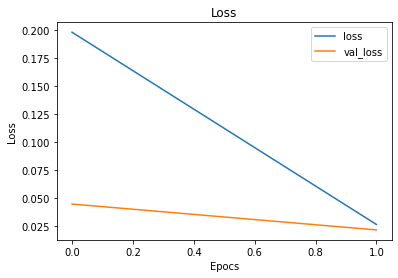

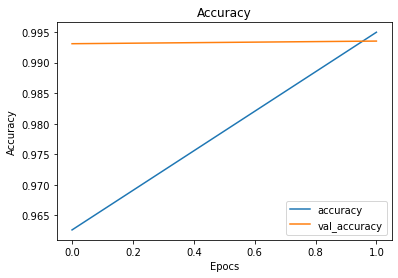

In [59]:
plot_history(history_multi)

In [0]:
# Uncomment if you want to show the merged model...

#tf.keras.utils.plot_model(model)
#model.summary()